# Importing Dependencies

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

import math
from sklearn.metrics import mean_squared_error

# Loading Data

In [6]:
df = pd.read_csv('AAPL.csv')

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600


# Data Preprocessing

In [8]:
data = df['Close'].loc[df['Date']>'2010-01-01'].reset_index(drop=True)

In [9]:
data.head()

0    7.643214
1    7.656429
2    7.534643
3    7.520714
4    7.570714
Name: Close, dtype: float64

In [10]:
data.tail()

3459    173.75000
3460    172.39999
3461    173.66000
3462    174.91000
3463    177.49001
Name: Close, dtype: float64

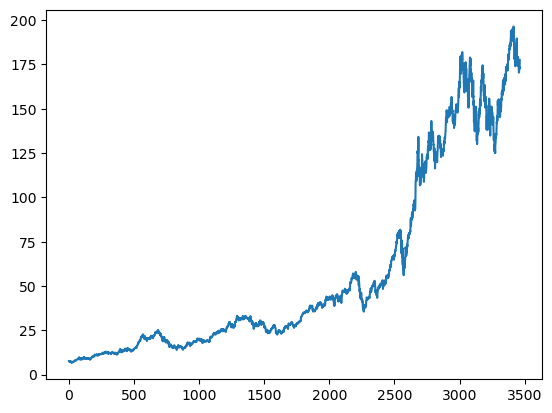

In [11]:
plt.plot(data)

In [12]:
stdscaler = StandardScaler()

In [13]:
data = stdscaler.fit_transform(np.array(data).reshape(-1,1))

In [15]:
training_size = int(0.8*len(data[:, 0]))
test_size = len(data[:, 0]) - training_size

In [17]:
training_size, test_size

(2771, 693)

In [18]:
train_data = data[0: training_size]
test_data = data[training_size: len(data[:, 0])]

In [19]:
def XySplit(data, time_window = 20):
    X = []
    y = []
    for i in range(0, len(data[:, 0])-time_window-1):
        X.append(data[i:i+time_window, 0])
        y.append(data[i+time_window, 0])
    return np.array(X), np.array(y)

In [20]:
time_window = 100

In [21]:
X_train, y_train = XySplit(train_data, time_window)
X_test, y_test = XySplit(test_data, time_window)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2670, 100), (2670,), (592, 100), (592,))

In [23]:
X_train =X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model

In [24]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.5))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1))

In [25]:
model.compile(loss ='mean_squared_error', optimizer = Adam(learning_rate = 0.0001))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

# Training

In [27]:
def trainer(epochs, verbose):
    model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, batch_size=64, verbose=verbose)

In [37]:
def report():
    train_predict=stdscaler.inverse_transform(model.predict(X_train))
    test_predict=stdscaler.inverse_transform(model.predict(X_test))
    
    print(f'\n\nTrain RMSE Loss: {math.sqrt(mean_squared_error(y_train,train_predict))}')
    print(f'\n\nTest RMSE Loss: {math.sqrt(mean_squared_error(y_test,test_predict))}\n\n')
    
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_window:len(train_predict)+time_window, :] = train_predict

    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_window*2)+1:len(data)-1, :] = test_predict
    
    plt.plot(stdscaler.inverse_transform(data), color = 'black')
    plt.plot(trainPredictPlot, color = 'cyan')
    plt.plot(testPredictPlot, color = 'red')
    plt.legend(['Actual Data', 'Train Predict', 'Test Predict'])
    plt.title('Actual vs Predicted values')
    plt.show()
    
    plt.plot(stdscaler.inverse_transform(y_train.reshape(-1,1)), color = 'black')
    plt.plot(train_predict, color = 'cyan')
    plt.legend(['Actual Data', 'Train Predict'])
    plt.title('Actual Training vs Predicted Training values')
    plt.show()
    
    plt.plot(stdscaler.inverse_transform(y_test.reshape(-1,1)), color = 'black')
    plt.plot(test_predict, color = 'red')
    plt.legend(['Actual Data', 'Test Predict'])
    plt.title('Actual Testing vs Predicted Testing values')
    plt.show()

In [29]:
trainer(100, 1)

Epoch 1/100
42/42 [==============================] - 28s 560ms/step - loss: 0.2906 - val_loss: 2.4882
Epoch 2/100
42/42 [==============================] - 12s 292ms/step - loss: 0.0638 - val_loss: 1.6833
Epoch 3/100
42/42 [==============================] - 13s 312ms/step - loss: 0.0366 - val_loss: 0.9469
Epoch 4/100
42/42 [==============================] - 11s 268ms/step - loss: 0.0244 - val_loss: 0.3257
Epoch 5/100
42/42 [==============================] - 11s 258ms/step - loss: 0.0177 - val_loss: 0.1547
Epoch 6/100
42/42 [==============================] - 11s 255ms/step - loss: 0.0168 - val_loss: 0.1320
Epoch 7/100
42/42 [==============================] - 11s 259ms/step - loss: 0.0164 - val_loss: 0.1548
Epoch 8/100
42/42 [==============================] - 11s 256ms/step - loss: 0.0160 - val_loss: 0.1580
Epoch 9/100
42/42 [==============================] - 11s 257ms/step - loss: 0.0159 - val_loss: 0.1301
Epoch 10/100
42/42 [==============================] - 11s 261ms/step - loss: 0.015

42/42 [==============================] - 10s 248ms/step - loss: 0.0100 - val_loss: 0.0288
Epoch 81/100
42/42 [==============================] - 10s 250ms/step - loss: 0.0094 - val_loss: 0.0217
Epoch 82/100
42/42 [==============================] - 10s 250ms/step - loss: 0.0095 - val_loss: 0.0155
Epoch 83/100
42/42 [==============================] - 10s 250ms/step - loss: 0.0098 - val_loss: 0.0349
Epoch 84/100
42/42 [==============================] - 10s 248ms/step - loss: 0.0091 - val_loss: 0.0156
Epoch 85/100
42/42 [==============================] - 11s 252ms/step - loss: 0.0097 - val_loss: 0.0170
Epoch 86/100
42/42 [==============================] - 11s 250ms/step - loss: 0.0086 - val_loss: 0.0251
Epoch 87/100
42/42 [==============================] - 10s 250ms/step - loss: 0.0098 - val_loss: 0.0149
Epoch 88/100
42/42 [==============================] - 10s 250ms/step - loss: 0.0087 - val_loss: 0.0180
Epoch 89/100
42/42 [==============================] - 11s 251ms/step - loss: 0.0093 - 

# Result Analysis

19/19 [==============================] - 1s 28ms/step


Train RMSE Loss: 42.24583472707084


Test RMSE Loss: 153.50675320960573




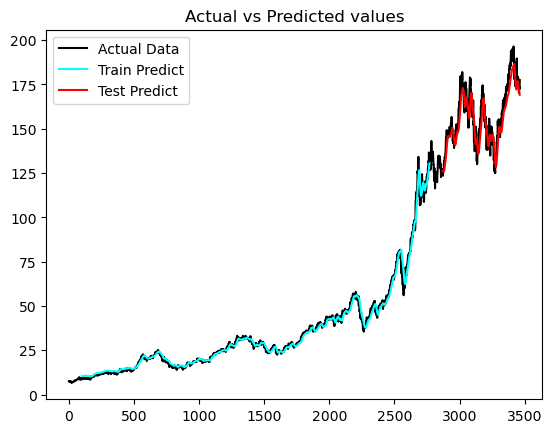

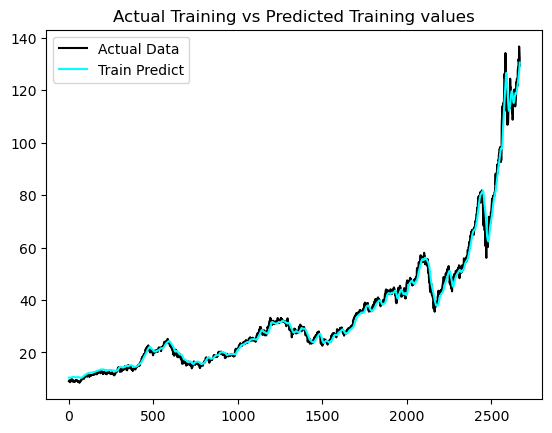

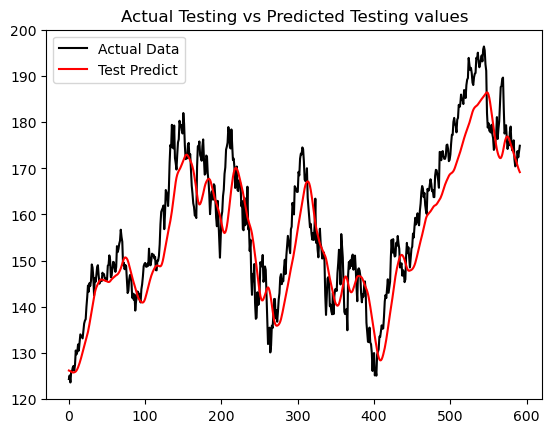

In [38]:
report()

# Tested Models

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

lr = 0.001

train loss: 42.53407718394477

test loss: 147.45663506622907

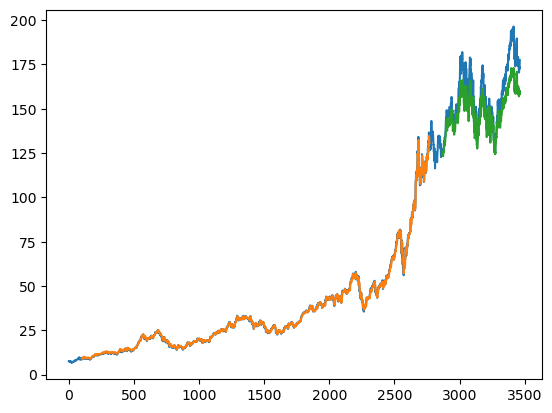

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.25))
model.add(LSTM(25,return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(25))
model.add(Dropout(0.25))
model.add(Dense(1))

lr = 0.0001

train_loss: 42.52218436865986

test_loss: 140.759728056867

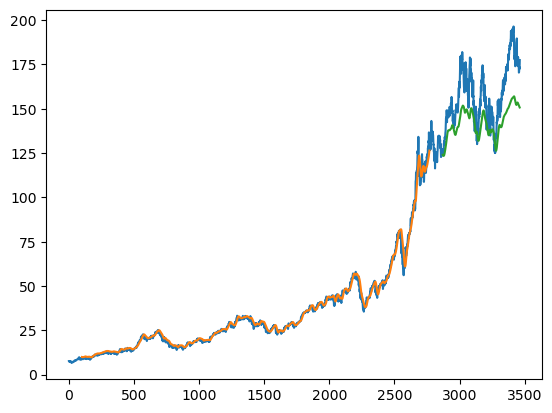

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.25))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(50))
model.add(Dropout(0.25))
model.add(Dense(1))

lr = 0.0001

train_loss: 42.357468163747015

test_loss: 150.1653993070135

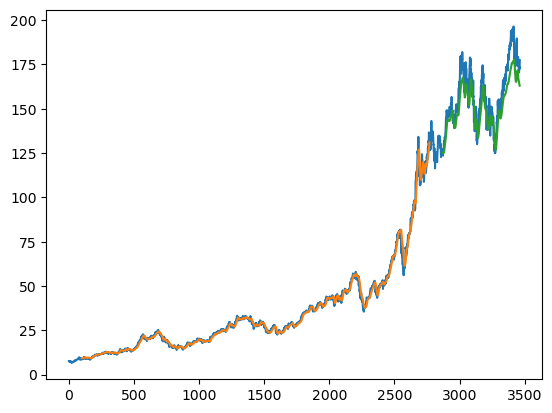

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.5))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1))

lr = 0.0001

train_loss: 42.74031398132778

test_loss: 150.3392457216271

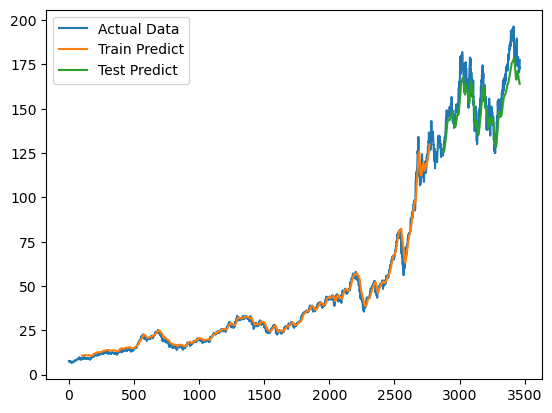

In [39]:
#R4Z0Rx